# 策略

## 选股
### 范围
    - NASDAQ100
### 细筛
    - 基本面？
    - PE？PEG？

## 择时
    - 唐安奇通道
    - BT暴跌反转

## 仓位管理
    - 平均分
    - 随机平均
    - 优先首次突破
    
## 止盈止损
    - 落袋平安
    - 时间上限
    - 持续策略

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
# import empyrical as emp
import time
import random
# from concurrent.futures import ProcessPoolExecutor

from common.log import *
from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
NASDAQ100 = CONF['NASDAQ100']
# print(NASDAQ100)
# NASDAQ100 = ['NDX', 'TSLA', 'NVDA', 'AMZN', 'GOOGL', 'GOOG', 'BIDU', 'FB', 'JD']
BENCHMARK = 'NDX'

pd

<module 'pandas' from '/usr/local/lib/python3.6/site-packages/pandas/__init__.py'>

In [2]:
%%time

spider = Spider_nasdaq()
timeframe = '10y'
ignore = True

for symbol in NASDAQ100:
# for symbol in ['NDX', 'TSLA']:
#     if symbol == 'VRTX':
#         ignore = False
#     if ignore:
#         continue
#     datafile = spider.get_stock_data(symbol, timeframe)
#     print(datafile)
    pass

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 43.6 µs


In [3]:
%%time

### 时间设置
start_date = '2008-01-01'
# start_date = '2010-01-01'
# start_date = '2015-01-01'
# start_date = '2017-01-01'
# start_date = '2018-01-01'
end_date = '2018-08-01'

TURTLE_POS = 10
### Turtle System One - Short
TURTLE_SHORT_BUY_N = 20
TURTLE_SHORT_SELL_N = 20
### Turtle System Two - Long
TURTLE_LONG_BUY_N = 60
TURTLE_LONG_SELL_N = 60

### 业务设置
IS_HAPPYMONEY = False
IS_TAX = False
IS_SLIPPAGE = False
IS_RANDOM_BUY = True
IS_UNIQUE_BUY = False
IS_FILTER = True
IS_MARKETUP = True
START_MONEY = 100000
HAPPY_MONEY = 0
PROPERTY = START_MONEY
CASH = START_MONEY


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 28.1 µs


In [4]:
%%time

stock_df_dict = {}

for symbol in NASDAQ100[:]:
    stock_data_file = '../database/market/%s.csv' % symbol
    stock_df = pd.read_csv(stock_data_file)

    # 筛选字段
#     stock_df = stock_df.loc[:, ['date', 'open', 'close']]

    # 去掉Nasdaq行情首行的当天行情
    if symbol in NASDAQ100:
        stock_df = stock_df.drop([0])

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期
    # 1.48 s ± 45.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#     stock_df['date'] = stock_df['date'].apply(lambda x: pd.Period(x, freq='D'))

    # 445 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    stock_df = stock_df.assign(date=pd.to_datetime(stock_df['date']))  # need .index.to_period('D')

    # 476 ms ± 46.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#     stock_df['date'] = pd.to_datetime(stock_df['date'])  # need .index.to_period('D')
    
    # 转换字段格式
#     stock_df = stock_df.astype(dtype={'volume': 'float64'})

    # 用日期作索引，日期升序排序
    # 95.1 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
    if symbol in NASDAQ100:
        stock_df = stock_df[::-1]
    
    # 407 µs ± 5.07 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#     %timeit stock_df.set_index(['date'], inplace=False)

    # Wall time: 500 µs
    stock_df.set_index(['date'], inplace=True)
    
    # 305 µs ± 2.75 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#     stock_df = stock_df.sort_index(axis=0, ascending=True)
    
    # 822 µs ± 41.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
    stock_df.index = stock_df.index.to_period('D')

    # 计算涨跌幅
#     stock_df['c_pct_chg'] = stock_df.close.pct_change(1)
    stock_df['o_pct_chg'] = stock_df.open.pct_change(1)
    
    # Turtle指标
#     stock_df['TR1'] = abs(stock_df['high'] - stock_df['low'])
#     stock_df['TR2'] = abs(stock_df['high'] - stock_df['close'].shift())
#     stock_df['TR3'] = abs(stock_df['low'] - stock_df['close'].shift())
#     stock_df['TR'] = stock_df[['TR1', 'TR2', 'TR3']].max(axis=1)
#     stock_df['N'] = stock_df['TR'].rolling(20).mean()
#     stock_df['UNIT'] = (0.01 * START_MONEY) / (stock_df['N'])
    stock_df['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N] = stock_df['open'].rolling(TURTLE_SHORT_BUY_N).max()
    stock_df['ROLLING_%d_MIN' % TURTLE_SHORT_SELL_N] = stock_df['open'].rolling(TURTLE_SHORT_SELL_N).min()
    stock_df['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N] = stock_df['open'].rolling(TURTLE_LONG_BUY_N).max()
    stock_df['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N] = stock_df['open'].rolling(TURTLE_LONG_SELL_N).min()
#     stock_df['MA%d' % TURTLE_BUY_N] = stock_df['open'].rolling(TURTLE_BUY_N).mean()
#     stock_df['MA%d' % TURTLE_SELL_N] = stock_df['open'].rolling(TURTLE_SELL_N).mean()
#     stock_df['EWMA'] = stock_df['open'].ewm(alpha=0.1, adjust=False).mean()
#     stock_df['MA360'] = stock_df['open'].rolling(360).mean()
    stock_df['MA180'] = stock_df['open'].rolling(180).mean()
    stock_df['MA60'] = stock_df['open'].rolling(60).mean()
    stock_df['MA30'] = stock_df['open'].rolling(30).mean()
    
#     stock_df['ops'] = ''
#     stock_df['profit'] = 0
    
    # 减少数据
    # stock_df = stock_df['2016-01-01':]
    stock_df.dropna(how='any', inplace=True)
#     stock_df.drop(columns=['volume', 'TR1', 'TR2', 'TR3'], inplace=True)
    
    stock_df_dict[symbol] = stock_df
    
#     print(stock_df.head(10))
#     print(stock_df.dtypes)
#     print(stock_df.index[0])
#     print(type(stock_df.index[0]))

CPU times: user 2min 56s, sys: 402 ms, total: 2min 56s
Wall time: 2min 57s


In [5]:
# %matplotlib inline

# import matplotlib
# import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [30, 20]

# single_symbol = 'JD'
# df = stock_df_dict[single_symbol].tail(600).copy()
# df.columns
# # df.tail(10)
# # df[(df.open == df.rolling_60_max)]
# # df[(df.open >= df.rolling_60_max) & (df.MA30 > df.MA60)]
# # df[(df.MA30 > df.MA60)]

# # df = df.loc[:, ['open', 'ROLLING_60_MAX', 'rolling_30_min', 'MA60', 'MA30']]

# df.reset_index(drop=False, inplace=True)
# df = df.astype(dtype={'date': 'datetime64[ns]'})
# df.set_index('date', inplace=True)
# # df.index.astype()

# display_charts(df, chart_type='stock', kind='line', y=['open', 'ROLLING_60_MAX', 'ROLLING_60_MIN'], figsize=(900, 600), title=single_symbol)

# # display_charts(df)

# # ax = df.plot(kind='line', y=['open', 'rolling_max', 'rolling_min'], label='', linewidth=1)

# # sum_buy_sig_short = 0
# # sum_buy_sig_long = 0
# # for symbol in NASDAQ100:
# #     tdf = stock_df_dict[symbol]
# #     buy_sig_short = tdf[(stock_df_dict[symbol].open == stock_df_dict[symbol]['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N])]
# #     buy_sig_long = tdf[(stock_df_dict[symbol].open == stock_df_dict[symbol]['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N])]
# #     buy_sig_short_2 = buy_sig_short[buy_sig_short.MA30 >= buy_sig_short.MA180]
# #     buy_sig_long_2 = buy_sig_long[buy_sig_long.MA30 >= buy_sig_long.MA180]
# # #     print(symbol, len(tdf), len(buy_sig_short), len(buy_sig_short_2), len(buy_sig_long), len(buy_sig_long_2))
# #     sum_buy_sig_short += len(buy_sig_short_2)
# #     sum_buy_sig_long += len(buy_sig_long_2)
# # print(len(stock_df_dict['NDX']), sum_buy_sig_short, sum_buy_sig_long)

In [6]:
# algo = stock_df_dict['TSLA'].open.pct_change()
# benchmark = stock_df_dict['NDX'].open.pct_change()

# 'cum_returns', emp.cum_returns(algo)[-1]
# 'max_drawdown', emp.max_drawdown(algo), emp.max_drawdown(benchmark)
# 'annual_return', emp.annual_return(algo), emp.annual_return(benchmark)
# 'annual_volatility', emp.annual_volatility(algo, period='daily')
# 'calmar_ratio', emp.calmar_ratio(algo)
# 'sharpe_ratio', emp.sharpe_ratio(returns=algo)
# 'alpha', emp.alpha(returns=algo, factor_returns=benchmark, risk_free=0.00)
# 'beta', emp.beta(returns=algo, factor_returns=benchmark, risk_free=0.00)

# emp_df = None
# emp_df = pd.DataFrame(columns=[
#     'symbol', 'cum_returns', 'annual_return', 'annual_volatility', 'max_drawdown', 'alpha', 'beta', 'sharpe_ratio', 'calmar_ratio'
# ])

# for symbol in NASDAQ100:
#     algo = stock_df_dict[symbol].open.pct_change()
#     emp_df = emp_df.append(
#         {
#             'symbol': symbol,
#             'cum_returns': emp.cum_returns(algo)[-1],
#             'annual_return': emp.annual_return(algo),
#             'annual_volatility': emp.annual_volatility(algo, period='daily'),
#             'max_drawdown': emp.max_drawdown(algo),
#             'alpha': round(emp.alpha(returns=algo, factor_returns=benchmark, risk_free=0.00), 2),
#             'beta': round(emp.beta(returns=algo, factor_returns=benchmark, risk_free=0.00), 2),
#             'sharpe_ratio': emp.sharpe_ratio(returns=algo),
#             'calmar_ratio': emp.calmar_ratio(algo)
#         },
#         ignore_index=True,
#     )

# # emp_df
# # emp_df.sort_values('cum_returns', ascending=False)
# # emp_df.sort_values('sharpe_ratio', ascending=False)

In [7]:
%%time

show_df = None
show_df = stock_df_dict['NDX'].copy()

CPU times: user 1 ms, sys: 0 ns, total: 1 ms
Wall time: 842 µs


In [8]:
%%time
# %xmode

PROPERTY = START_MONEY
CASH = START_MONEY

order_df = None
order_df = pd.DataFrame(columns=[
    'buy_date', 'symbol', 'buy_count', 'buy_price', 'buy_reason', 'sell_date', 'sell_price', 'sell_reason', 'profit', 'cash', 'property'
])
count_day = 0
yesterday = None
miss_buy_short = 0
miss_buy_long = 0

for today in pd.period_range(start=start_date, end=end_date, freq='D'):
    count_day += 1
    
    # 新的一年筛股
    if IS_FILTER and (today.dayofyear == 1 or count_day == 1):
#         print(today)
        NASDAQ100 = (Config().data[0])['NASDAQ100']
        benchmark_lastyear = stock_df_dict[BENCHMARK][:today]
        if today - stock_df_dict[BENCHMARK].iloc[0].name < 250:
            continue
        if len(benchmark_lastyear) < 250:
            continue
#         print(today - stock_df_dict[BENCHMARK].iloc[0].name)
#         print(benchmark_lastyear)
        benchmark_return_lastyear = benchmark_lastyear.iloc[-1].open / benchmark_lastyear.iloc[-250].open
        for symbol, stock_df in stock_df_dict.items():
            try:
                return_lastyear = stock_df[:today].iloc[-1].open / stock_df[:today].iloc[-250].open
                if return_lastyear < benchmark_return_lastyear:
                    NASDAQ100.remove(symbol)
#                     print(symbol, return_lastyear)
            except:
                NASDAQ100.remove(symbol)
                pass
        print(today, 'NASDAQ100 after filter', len(NASDAQ100))
    
    if yesterday is None:
        yesterday = today
        continue

    if today not in stock_df_dict['NDX'].index:
        continue
        
    # 突破下行趋势，清仓退出
    order_arr = order_df.to_records(index=False)
    if len(order_arr[(order_arr.buy_count > 0) & (order_arr.sell_price == 0)] ) != 0:
        is_sell = False
        for idx in order_df[(order_df['buy_count'] > 0) & (order_df['sell_price'] == 0)].index:
            cur_order = order_df.loc[idx]
            symbol = cur_order['symbol']
            if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
                continue
            today_market = stock_df_dict[symbol].loc[today]
            if cur_order.buy_reason == 'SHORT':
                is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_SHORT_SELL_N])
            if cur_order.buy_reason == 'LONG':
                is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N])
            if is_sell:
                CASH += cur_order.buy_count * today_market.open
                order_df.loc[idx, 'sell_date'] = today
                order_df.loc[idx, 'sell_price'] = today_market.open
                order_df.loc[idx, 'sell_reason'] = 'EXIT'
                order_df.loc[idx, 'profit'] = \
                    (today_market.open - cur_order.buy_price) * cur_order.buy_count
#                 print(today, '退出', stock_df_dict[symbol].loc[today, 'open'], CASH)

    if IS_HAPPYMONEY:        
        if PROPERTY > START_MONEY * 2:
            HAPPY_MONEY += 50000
            PROPERTY -= 50000
            CASH = PROPERTY
    
    benchmark_today_market = stock_df_dict[BENCHMARK].loc[today]
    # 买卖过程
    for symbol in NASDAQ100[:]:
#     for symbol in ['TSLA']:

        if IS_MARKETUP:
            if benchmark_today_market.MA60 < benchmark_today_market.MA180:
                break

        if symbol in ['ALGN', 'ROST', 'ORLY', 'ESRX', 'ULTA', 'REGN', 'MNST']:
#             continue
            pass

        if symbol == 'NDX':
            continue
        
        if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
            continue
            
        # TIME TEST
#         print(order_df)
#         print(order_df.columns)
        
#         %timeit (len(order_df[order_df['symbol'] == symbol]) != 0)
#         %timeit order_df[order_df['symbol'] == symbol].shape[0] != 0
#         %timeit n_order_df = order_df.values
#         %timeit len(n_order_df[n_order_df[:, 1] == symbol]) != 0
#         %timeit (len(order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)]) == 0)


#         iiidx = stock_df_dict[symbol].index.get_loc(today)
#         print(iiidx, type(iiidx))
#         %timeit stock_df_dict[symbol].loc[today]
#         %timeit n_stock_df = stock_df_dict[symbol].values
#         %timeit n_stock_df[iiidx]
        
#         %timeit (stock_df_dict[symbol].loc[today, 'open'] >= stock_df_dict[symbol].loc[today, 'rolling_max'])
#         %timeit (stock_df_dict[symbol].loc[today, 'open'] >= stock_df_dict[symbol].loc[today, 'rolling_max'])

#         %timeit int(stock_df_dict[symbol].shift(1).loc[today, 'Unit'])
#         %timeit int(CASH / stock_df_dict[symbol].loc[today, 'open'])
#         %timeit buy_count * stock_df_dict[symbol].loc[today, 'open']
#         %timeit stock_df_dict[symbol]
#         %timeit stock_df_dict[symbol].loc[today, 'open']
#         %timeit (stock_df_dict[symbol].loc[today, 'open'] > order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)].buy_price.iloc[-1] + 0.5 * stock_df_dict[symbol].shift(1).loc[today, 'N'])
        
#         n_order_df = order_df.values
#         n_stock_df = stock_df_dict[symbol].values
#         today_idx = stock_df_dict[symbol].index.get_loc(today)
#         is_has_order = (len(n_order_df[n_order_df[:, 1] == symbol]) != 0)
#         is_order_soldout = not is_has_order and (len(n_order_df[n_order_df[:, 6] == symbol]) == 0)
        
#         is_has_order = (len(order_df[order_df['symbol'] == symbol]) != 0)
#         is_order_soldout = (len(order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)]) == 0)
        
    
#         '''
#         'buy_date', 'symbol', 'buy_count', 'buy_price', 'buy_reason', 'sell_date', 'sell_price', 'sell_reason', 'profit', 'cash', 'property'
#         stock_df['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N] = stock_df['open'].rolling(TURTLE_SHORT_BUY_N).max()
#         stock_df['ROLLING_%d_MIN' % TURTLE_SHORT_SELL_N] = stock_df['open'].rolling(TURTLE_SHORT_SELL_N).min()
#         stock_df['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N] = stock_df['open'].rolling(TURTLE_LONG_BUY_N).max()
#         stock_df['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N] = stock_df['open'].rolling(TURTLE_LONG_SELL_N).min()
#         '''

        today_market = stock_df_dict[symbol].loc[today]

        # 突破上行趋势，就买一份
        order_arr = order_df.to_records(index=False)
        if today_market.MA60 >= today_market.MA180:
#         if today_market.MA30 >= today_market.MA60:
#         if today_market.MA30 >= today_market.MA360:
#         if today_market.MA30 >= today_market.MA180:
#         if today_market.MA60 >= today_market.MA360:
            is_buy = False
            if today_market.open >= today_market['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N]:
                is_buy = True
                buy_reason = 'LONG'
            elif False and today_market.open >= today_market['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N]:
                is_buy = True
                buy_reason = 'SHORT'
            if is_buy:
                buy_count = 0
                
                if IS_SLIPPAGE:
                    buy_price = today_market.open * (1 + random.randint(0, 20) / 1000)
                else:
                    buy_price = today_market.open

#                 if CASH >= START_MONEY / TURTLE_POS:
#                     buy_count = int((START_MONEY / TURTLE_POS) / buy_price)
                    
                if CASH >= PROPERTY / TURTLE_POS:
                    buy_count = int((PROPERTY / TURTLE_POS) / buy_price)
                
                if IS_RANDOM_BUY:
                    if random.randint(0, 100) > 50:
                        buy_count = 0
                
                if IS_UNIQUE_BUY:
                    if len(order_arr[(order_arr.symbol == symbol) & (order_arr.sell_price == 0)] ) != 0:
#                         buy_count = 1
                        pass
                    else:
#                         buy_count = 10
                        pass

#                 buy_count = 1
                if buy_count > 0:
                    CASH -= buy_count * buy_price
#                     print(today, '建仓', buy_count, stock_df_dict[symbol].loc[today, 'open'], CASH)
                    order_df = order_df.append(
                        {
                            'buy_date': today,
                            'symbol': symbol,
                            'buy_count': buy_count,
                            'buy_price': today_market.open,
                            'buy_reason': buy_reason,
                            'sell_date': pd.np.nan,
                            'sell_price': 0,
                            'profit': 0,
                            'cash': CASH,
                            'property': PROPERTY,
                        },
                        ignore_index=True
                    )
                else:
                    if buy_reason == 'LONG':
                        miss_buy_long += 1
                    elif buy_reason == 'SHORT':
                        miss_buy_short += 1
            
    # 每天盘点财产
    show_df.loc[today, 'CASH_TURTLE_%d_%d_%d' % (TURTLE_POS, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)] = CASH
    PROPERTY = CASH + \
        sum(
            [
                stock_df_dict[order_df.loc[idx, 'symbol']][:today].iloc[-1].open * order_df.loc[idx, 'buy_count'] \
                for idx in order_df.loc[order_df['sell_price']==0].index
            ]
        )
    show_df.loc[today, 'PROPERTY_TURTLE_%d_%d_%d' % (TURTLE_POS, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)] = PROPERTY

    yesterday = today


    
# 最后一天，清仓
order_arr = order_df.to_records(index=False)
for idx in order_df[order_df['sell_price'] == 0].index:
    cur_order = order_df.loc[idx]
    symbol = cur_order['symbol']
    today_market = stock_df_dict[symbol][:today].iloc[-1]
    CASH += cur_order.buy_count * today_market.open
    order_df.loc[idx, 'sell_date'] = today
    order_df.loc[idx, 'sell_price'] = today_market.open
    order_df.loc[idx, 'sell_reason'] = 'EXIT'
    order_df.loc[idx, 'profit'] = \
        (today_market.open - cur_order.buy_price) * cur_order.buy_count


print(CASH)
print(HAPPY_MONEY)
print(PROPERTY)

s_p = stock_df_dict['NDX'][start_date:].iloc[0].open
e_p = stock_df_dict['NDX'][:end_date].iloc[-1].open
print('NDX', s_p, e_p, e_p / s_p)


2011-01-01 NASDAQ100 after filter 51
2012-01-01 NASDAQ100 after filter 60
2013-01-01 NASDAQ100 after filter 48
2014-01-01 NASDAQ100 after filter 64
2015-01-01 NASDAQ100 after filter 55
2016-01-01 NASDAQ100 after filter 47
2017-01-01 NASDAQ100 after filter 56
2018-01-01 NASDAQ100 after filter 44
704868.6733000001
0
704868.6733000001
NDX 1327.02 7404.56 5.579840544980483
CPU times: user 7min 50s, sys: 783 ms, total: 7min 50s
Wall time: 7min 54s


In [9]:
'ALL'
'start_date', start_date
'end_date', end_date
'TURTLE_POS', TURTLE_POS
'TURTLE_SHORT_BUY_N', TURTLE_SHORT_BUY_N
'TURTLE_SHORT_SELL_N', TURTLE_SHORT_SELL_N
'TURTLE_LONG_BUY_N', TURTLE_LONG_BUY_N
'TURTLE_LONG_SELL_N', TURTLE_LONG_SELL_N
'IS_HAPPYMONEY', IS_HAPPYMONEY
'IS_TAX', IS_TAX
'IS_SLIPPAGE', IS_SLIPPAGE
'IS_RANDOM_BUY', IS_RANDOM_BUY
'START_MONEY', START_MONEY

'len(order_df)', len(order_df)
sum_profit = sum(list(order_df['profit']))
'sum_profit', sum_profit
# sum_tax = sum(list(order_df_TB['tax']))
sum_tax = 0
'sum_tax', sum_tax
'win rate', len(order_df[order_df.profit > 0]) / len(order_df[order_df.profit != 0])
'annual_return', ((sum_profit - sum_tax) / START_MONEY + 1) ** (365 / count_day)
'len(order_df[order_df.profit != 0])', len(order_df[order_df.profit != 0])
'len(order_df[order_df.profit > 0])', len(order_df[order_df.profit > 0])
'order LONG', len(order_df[order_df.buy_reason == 'LONG'])
len(order_df[(order_df.buy_reason == 'LONG') & (order_df.profit > 0)])
sum(list(order_df[order_df.buy_reason == 'LONG']['profit']))
'order SHORT', len(order_df[order_df.buy_reason == 'SHORT'])
len(order_df[(order_df.buy_reason == 'SHORT') & (order_df.profit > 0)])
sum(list(order_df[order_df.buy_reason == 'SHORT']['profit']))

# order_df
# order_df.loc[order_df['sell_price']==0]

calc_df = order_df.copy()
calc_df['profit_pct'] = calc_df['profit'] / (calc_df['buy_count'] * calc_df['buy_price'])
# calc_df[calc_df.symbol == 'BIDU']
# calc_df[calc_df.profit > 0]
# calc_df

# order_df[order_df.profit > 0]

# csv_file = 'E:/Dev/result/T_TURTLE_POS%d_TURTLE_BUY_N%d_TURTLE_SELL_N%d_START_MONEY%d_%s_%s.csv' % \
#     (TURTLE_POS, TURTLE_BUY_N, TURTLE_SELL_N, START_MONEY, start_date, end_date)
# calc_df.to_csv(csv_file)

# list(show_df.dropna(how='any', inplace=False).PROPERTY_TURTLE_20_60_60.apply(int).tail(50))
# list(show_df.open.apply(int).tail(50))

df = show_df.dropna(how='any', inplace=False).copy()
# algo = df['PROPERTY_TURTLE_%d_%d_%d' % (TURTLE_POS, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)].pct_change()
# benchmark = df.open.pct_change()

# 'cum_returns', emp.cum_returns(algo)[-1], emp.cum_returns(benchmark)[-1]
# 'max_drawdown', emp.max_drawdown(algo), emp.max_drawdown(benchmark)
# 'annual_return', emp.annual_return(algo), emp.annual_return(benchmark)
# 'annual_volatility', emp.annual_volatility(algo, period='daily')
# 'calmar_ratio', emp.calmar_ratio(algo)
# 'sharpe_ratio', emp.sharpe_ratio(returns=algo)
# 'alpha', emp.alpha(returns=algo, factor_returns=benchmark, risk_free=0.00)
# 'beta', emp.beta(returns=algo, factor_returns=benchmark, risk_free=0.00)

'ALL DAY', len(df)
'CASH_TURTLE_%d_%d_%d' % (TURTLE_POS, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)
'PROPERTY_TURTLE_%d_%d_%d' % (TURTLE_POS, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)
'CASH NOT USED DAY', \
    len(df[df['CASH_TURTLE_%d_%d_%d' % (TURTLE_POS, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)] > \
           df['PROPERTY_TURTLE_%d_%d_%d' % (TURTLE_POS, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)] / TURTLE_POS])
'MISS_BUY_SIGNAL_LONG', miss_buy_long
'MISS_BUY_SIGNAL_SHORT', miss_buy_short

'ALL'

('start_date', '2008-01-01')

('end_date', '2018-08-01')

('TURTLE_POS', 10)

('TURTLE_SHORT_BUY_N', 20)

('TURTLE_SHORT_SELL_N', 20)

('TURTLE_LONG_BUY_N', 60)

('TURTLE_LONG_SELL_N', 60)

('IS_HAPPYMONEY', False)

('IS_TAX', False)

('IS_SLIPPAGE', False)

('IS_RANDOM_BUY', True)

('START_MONEY', 100000)

('len(order_df)', 147)

('sum_profit', 604868.6733)

('sum_tax', 0)

('win rate', 0.5714285714285714)

('annual_return', 1.2024645895590236)

('len(order_df[order_df.profit != 0])', 147)

('len(order_df[order_df.profit > 0])', 84)

('order LONG', 147)

84

604868.6733

('order SHORT', 0)

0

0

('ALL DAY', 2339)

'CASH_TURTLE_10_60_60'

'PROPERTY_TURTLE_10_60_60'

('CASH NOT USED DAY', 485)

('MISS_BUY_SIGNAL_LONG', 12605)

('MISS_BUY_SIGNAL_SHORT', 0)

In [10]:
df = order_df.copy()
df

,buy_date,symbol,buy_count,buy_price,buy_reason,sell_date,sell_price,sell_reason,profit,cash,property
0,2009-05-28,ADI,415,24.0800,LONG,2009-10-29,25.93,EXIT,767.75,90006.8000,100000
1,2009-05-28,AAPL,524,19.0643,LONG,2010-08-24,34.6671,EXIT,8175.87,80017.1068,100000
2,2009-05-28,MXIM,628,15.9000,LONG,2009-10-30,16.88,EXIT,615.44,70031.9068,100000
3,2009-05-29,ADI,414,24.1500,LONG,2009-10-29,25.93,EXIT,736.92,60033.8068,100000
4,2009-05-29,EXPE,633,15.7878,LONG,2010-01-20,22.0402,EXIT,3957.77,50040.1294,100000
5,2009-05-29,NTES,288,34.7100,LONG,2009-10-13,38.92,EXIT,1212.48,40043.6494,100000
6,2009-05-29,TXN,518,19.3000,LONG,2010-01-29,23.11,EXIT,1973.58,30046.2494,100000
7,2009-06-01,ADI,403,24.8400,LONG,2009-10-29,25.93,EXIT,439.27,20035.7294,100312
8,2009-06-01,AAPL,514,19.4957,LONG,2010-08-24,34.6671,EXIT,7798.1,10014.9396,100312
9,2009-06-24,VRTX,294,33.7000,LONG,2009-10-09,33.14,EXIT,-164.64,107.1396,99111.5


In [11]:
df = order_df.copy()
df.drop(columns=['sell_reason'], inplace=True)
df['pro_pct'] = (df.sell_price - df.buy_price) / df.buy_price
# df.sell_date.dtypes
# df.loc[1].sell_date
# df.loc[1].sell_date.to_timestamp()

# df = df.astype(dtype={'sell_date': 'datetime64[ns]', 'buy_date': 'datetime64[ns]', 'cash':'int'})
df = df.astype(dtype={'cash': 'int'})
# df.loc[1].sell_date

# type(df[1].sell_date)
df['h_days'] = (df.sell_date - df.buy_date)
# df.loc[1].h_days
# type(df.loc[1].h_days)

df['h_days'] = df['h_days'].apply(lambda x: 1 if x == 0 else x)
# df.loc[1].h_days

df['per_d'] = df.pro_pct / df.h_days * 365
# df['per_d'] = df.apply(lambda x: x.pro_pct / x.h_days)

df['curry_ret'] = df['symbol'].apply(lambda x: stock_df_dict[x].iloc[-1].open / stock_df_dict[x][start_date:].iloc[0].open)
# df['lasty_ret'] = df['symbol'].apply(lambda x: stock_df_dict[x][:start_date].iloc[-1].open / stock_df_dict[x][:start_date].iloc[-150].open)

df = df.astype(dtype={'per_d': 'float64', 'pro_pct': 'float64'})
# df.dtypes

# df
# df.sort_values(by='pro_pct', ascending=False)
# df.sort_values(by='per_d', ascending=False)

# df = df.loc[:, ['symbol', 'pro_pct', 'h_days']]
# df = df.groupby(by='symbol').sum()
# df = df.groupby('symbol')
# df['per_d'].agg('mean')
# df.sort_values(by='pro_pct', ascending=False).head(1000)


single_symbol = 'NVDA'
df.sort_values(by='pro_pct', ascending=False).loc[df.symbol==single_symbol]
df = stock_df_dict[single_symbol].tail(1000).copy()
# df.columns
df.reset_index(drop=False, inplace=True)
df = df.astype(dtype={'date': 'datetime64[ns]'})
df.set_index('date', inplace=True)
display_charts(df, chart_type='stock', y=['open', 'ROLLING_60_MAX', 'ROLLING_60_MIN'], figsize=(900, 600), title=single_symbol)

,buy_date,symbol,buy_count,buy_price,buy_reason,sell_date,sell_price,profit,cash,property,pro_pct,h_days,per_d,curry_ret
121,2016-05-25,NVDA,650,45.50,LONG,2017-04-11,96.55,33182.5,206049,296185,1.121978,321,1.275769,21.850305
126,2016-05-27,NVDA,650,45.70,LONG,2017-04-11,96.55,33052.5,57755,297143,1.112691,319,1.273142,21.850305
137,2017-08-07,NVDA,290,168.39,LONG,2018-08-01,251.06,23974.3,68340,488414,0.490944,359,0.499149,21.850305


In [12]:
# # %%time

# '''选股，计算哪些股票跑不赢指数'''

# df = None
# df = pd.DataFrame(columns=[
#     'symbol', 'return'
# ])

# s_p = stock_df_dict['NDX'][:start_date].iloc[-250].open
# e_p = stock_df_dict['NDX'][:start_date].iloc[-1].open
# benchmark_return = e_p / s_p
# s_p, e_p
# 'benchmark_return_lastyear', benchmark_return

# s_p = stock_df_dict['NDX'][start_date:].iloc[0].open
# e_p = stock_df_dict['NDX'][:end_date].iloc[-1].open
# benchmark_return = e_p / s_p
# 'benchmark_return', benchmark_return



# for symbol, stock_df in stock_df_dict.items():
#     df = df.append(
#         {
#             'symbol': symbol,
#             'return': stock_df[:end_date].iloc[-1].open / stock_df[start_date:].iloc[0].open,
#         },
#         ignore_index = True
#     )

# len(df[df['return'] < benchmark_return])

# # df[df['return'] >= benchmark_return]

# df.sort_values(by=['return'], ascending=False)


In [13]:
%matplotlib inline

import sys
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# order_df_TB
bar_df = order_df.copy()
df = bar_df.sort_values(by=['profit'])
# df

bins = [100 * x for x in range(-200, 500)]
# bins

cats = pd.cut(df['profit'], bins)
# cats

def get_stats(group):
    return {'count': group.count()}

grouped = df['profit'].groupby(cats)
bin_counts = grouped.apply(get_stats).unstack()
bin_counts.reset_index(inplace=True, drop=False)
bin_counts['profit'] = bin_counts['profit'].apply(str)
# bin_counts

# df['profit'].hist(bins=10)

# bin_counts.plot(kind='barh', alpha=0.5, rot=0)

# display_charts(bin_counts, kind='bar', x='profit', figsize=(900, 600), logy=True)

Index(['open', 'high', 'low', 'close', 'volume', 'o_pct_chg', 'ROLLING_20_MAX',
       'ROLLING_20_MIN', 'ROLLING_60_MAX', 'ROLLING_60_MIN', 'MA180', 'MA60',
       'MA30', 'CASH_TURTLE_10_60_60', 'PROPERTY_TURTLE_10_60_60'],
      dtype='object')

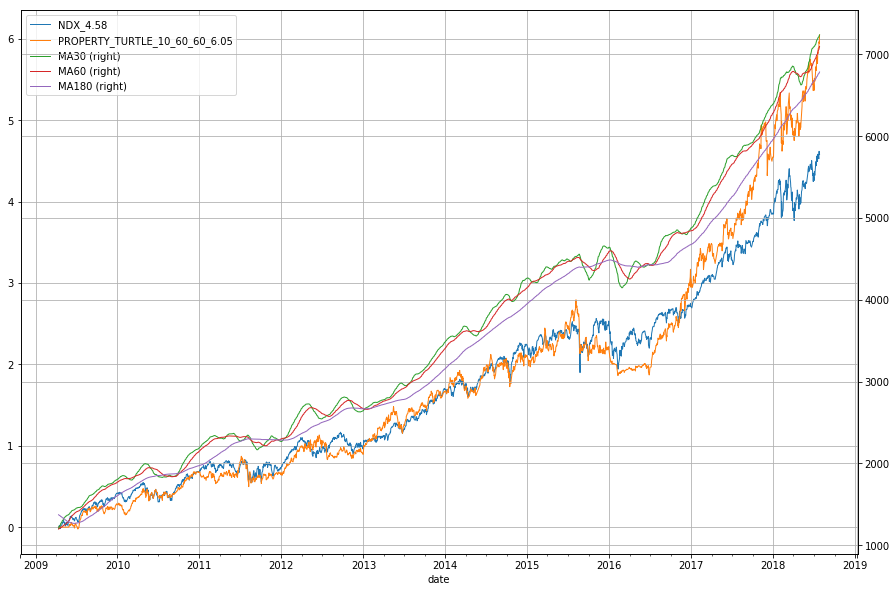

In [14]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

df = show_df.dropna(how='any', inplace=False).copy()
# df.drop(columns=['open', 'high', 'low', 'o_pct_chg', 'TR', 'N'], inplace=True)
df.columns

# df.iloc[0]['open']
# stock_df_dict['NDX'][start_date:].iloc[0].open
# stock_df_dict['NDX'][:end_date].iloc[-1].open
# df['open']

df['open'] = (df['open'] - df.iloc[0]['open']) / df.iloc[0]['open']
ax = df.plot(kind='line', y='open', label='NDX_%.2f' % df.iloc[-1]['open'], linewidth=1, grid=True)
for col in sorted(df.columns):
    if 'PROPERTY' in col:
        df[col] = (df[col] - df.iloc[1][col]) / df.iloc[0][col]
        ax = df.plot(kind='line', y=col, secondary_y=False, label='%s_%.2f' % (col, df.iloc[-1][col]), linewidth=1, grid=True, ax=ax)

ax = df.plot(kind='line', y='MA30', secondary_y=True, linewidth=1, grid=True, ax=ax)        
ax = df.plot(kind='line', y='MA60', secondary_y=True, linewidth=1, grid=True, ax=ax)
ax = df.plot(kind='line', y='MA180', secondary_y=True, linewidth=1, grid=True, ax=ax)

In [15]:
df = show_df.dropna(how='any', inplace=False).copy()
# df.drop(columns=['open', 'high', 'low', 'o_pct_chg', 'TR', 'N'], inplace=True)
df.columns

show_y = ['open']

df['open'] = (df['open'] - df.iloc[0]['open']) / df.iloc[0]['open']
for col in sorted(df.columns):
    if 'PROPERTY' in col:
        df[col] = (df[col] - df.iloc[1][col]) / df.iloc[0][col]
        show_y.append(col)
    if 'CASH' in col:
        df[col] = df[col] / df.iloc[0][col]
        show_y.append(col)

# df = df.loc[:, ['close', 'CASH_TURTLE_20_60_60', 'PROPERTY_TURTLE_20_60_60']]
# df = df.loc[:, ['close', 'CASH_TURTLE_100_60_60', 'PROPERTY_TURTLE_100_60_60']]
df = df.loc[:, show_y]

df.reset_index(drop=False, inplace=True)
# df.dtypes
# df.iloc[0].date
# df.iloc[0].date.to_timestamp()
# df.iloc[0].date.to_timestamp().to_datetime64()
df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
# df.iloc[0].date
df.set_index(keys=['date'], inplace=True)
# df

display_charts(df, chart_type='stock', figsize=(900, 800), logy=False)

Index(['open', 'high', 'low', 'close', 'volume', 'o_pct_chg', 'ROLLING_20_MAX',
       'ROLLING_20_MIN', 'ROLLING_60_MAX', 'ROLLING_60_MIN', 'MA180', 'MA60',
       'MA30', 'CASH_TURTLE_10_60_60', 'PROPERTY_TURTLE_10_60_60'],
      dtype='object')